In [1]:
#necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#modelling
#!pip install category_encoders
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import  XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from sklearn.compose import TransformedTargetRegressor
from category_encoders.cat_boost import CatBoostEncoder

#disable catboost warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#display config
pd.set_option('display.float_format', str)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#read data
train=pd.read_csv('/content/drive/MyDrive/Datascience_projects/Autotrader_SA/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Datascience_projects/Autotrader_SA/test.csv')

In [4]:
#check datasets details
print('Train shape :',train.shape)
print('Test shape :',test.shape)


Train shape : (11519, 26)
Test shape : (4937, 26)


In [5]:
#check duplicates
print('Number of duplicates in train :',train.duplicated().sum())
print('Number of duplicates in test :',test.duplicated().sum())

Number of duplicates in train : 0
Number of duplicates in test : 0


`since duplicates have been removed during the cleaning stage, it is expected that we will see zero duplicates in both set. but the check is still good for validation`

In [6]:
#check missing values details in train
train.isna().sum()

Brand                              0
Model                              0
Year                               0
Price                              0
Mileage                            0
Transmission                       0
Fuel Type                          0
Previous Owners                    0
Color                              7
Body Type                          2
Engine position                   85
Engine capacity (litre)           18
Cylinder layout and quantity      81
Seats (quantity)                  95
No of doors                        0
Front tyres                       69
Rear tyres                        81
Driven wheels                      0
Fuel capacity                     85
Fuel consumption (average)       435
Fuel range (average)             456
Power maximum (detail)            67
Torque maximum                    67
Acceleration 0-100 km/h         4491
Maximum/top speed               2584
CO2 emissions (average)          388
dtype: int64

`These missing values will be imputed during modelling using pipeline. The missing values will be imputed in train set first and then the imputer config. will be used to impute missing values in test set to avoid data leakage.`

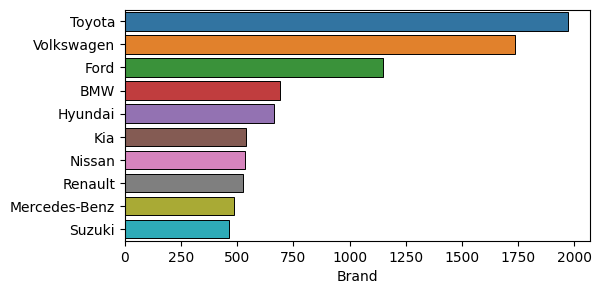

In [7]:
#most frequent brands in the dataset
plt.figure(figsize=(6,3))
sns.barplot(x=train['Brand'].value_counts()[:10],
          y=train['Brand'].value_counts()[:10].index, edgecolor='black',linewidth=0.7)
plt.show()

`Toyota is the most frequent used car brand in the dataset. this is true since the most popular car brand in South Africa is Toyota. After Toyota is Volkswagen and the rest.`

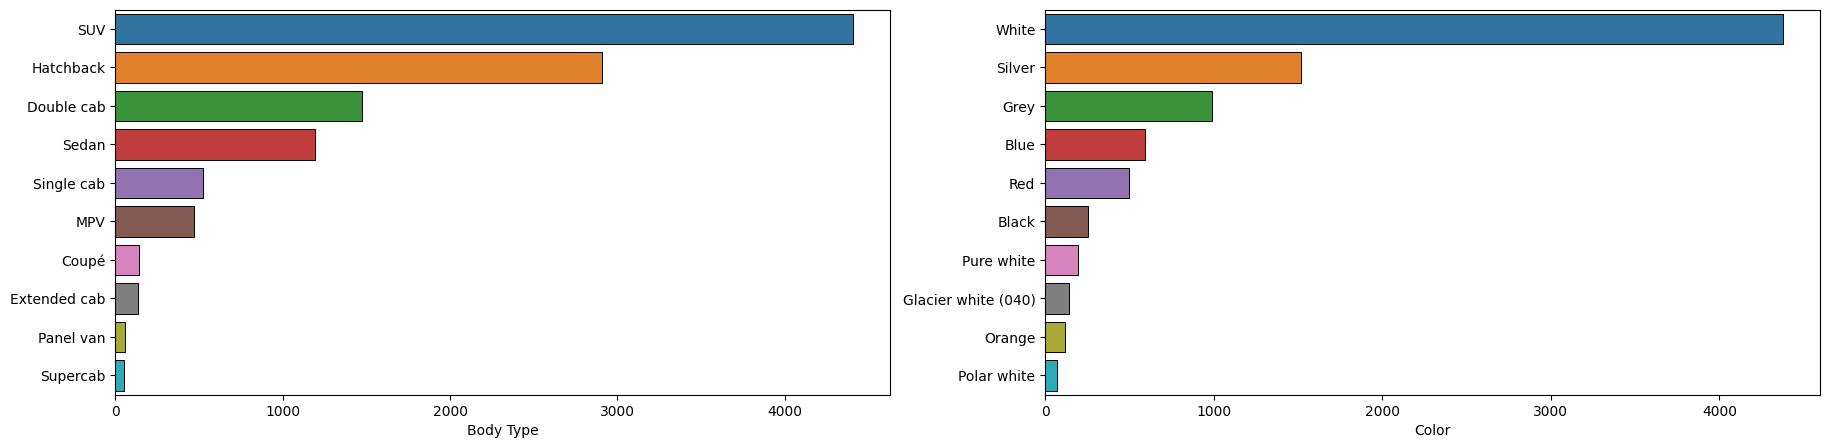

In [8]:
#Top 10 car Body Type and Color in the dataset
fig,ax=plt.subplots(1,2,figsize=(22,5))
sns.barplot(x=train['Body Type'].value_counts()[:10],y=train['Body Type'].value_counts()[:10].index, 
             edgecolor='black',linewidth=0.7,ax=ax[0])
sns.barplot(x=train['Color'].value_counts()[:10],y=train['Color'].value_counts()[:10].index, 
             edgecolor='black',linewidth=0.7,ax=ax[1])
plt.show()

`SUV dominates as the most popular used car brand sold on Autotrader South Africa, this is expected since SUV is the most popular car body type in South Africa also. With regards to color, the top 3 colors of used cars on the website are white,silver and grey.`

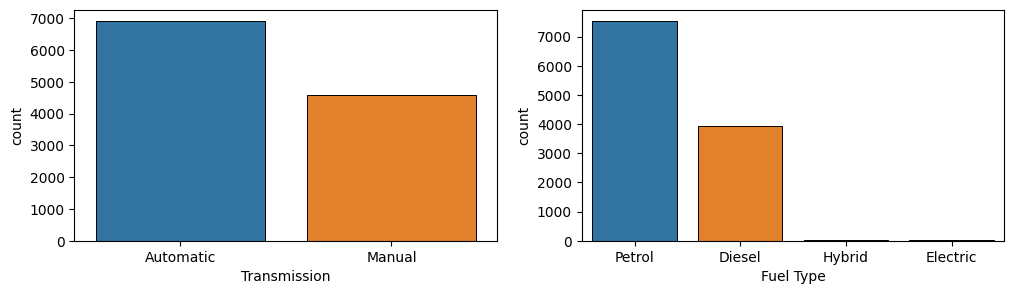

In [9]:
#Transmission and Fuel Type
fig,ax=plt.subplots(1,2,figsize=(12,3))
sns.countplot(x=train['Transmission'], edgecolor='black',linewidth=0.7,ax=ax[0])
sns.countplot(x=train['Fuel Type'], edgecolor='black',linewidth=0.7,ax=ax[1])
plt.show()

`There are more used cars with automatic transmission compared to the manual. with respect to fuel type, cars with petrol fuel type are most frequent, a very small number of cars have hybrid or electric fuel type`

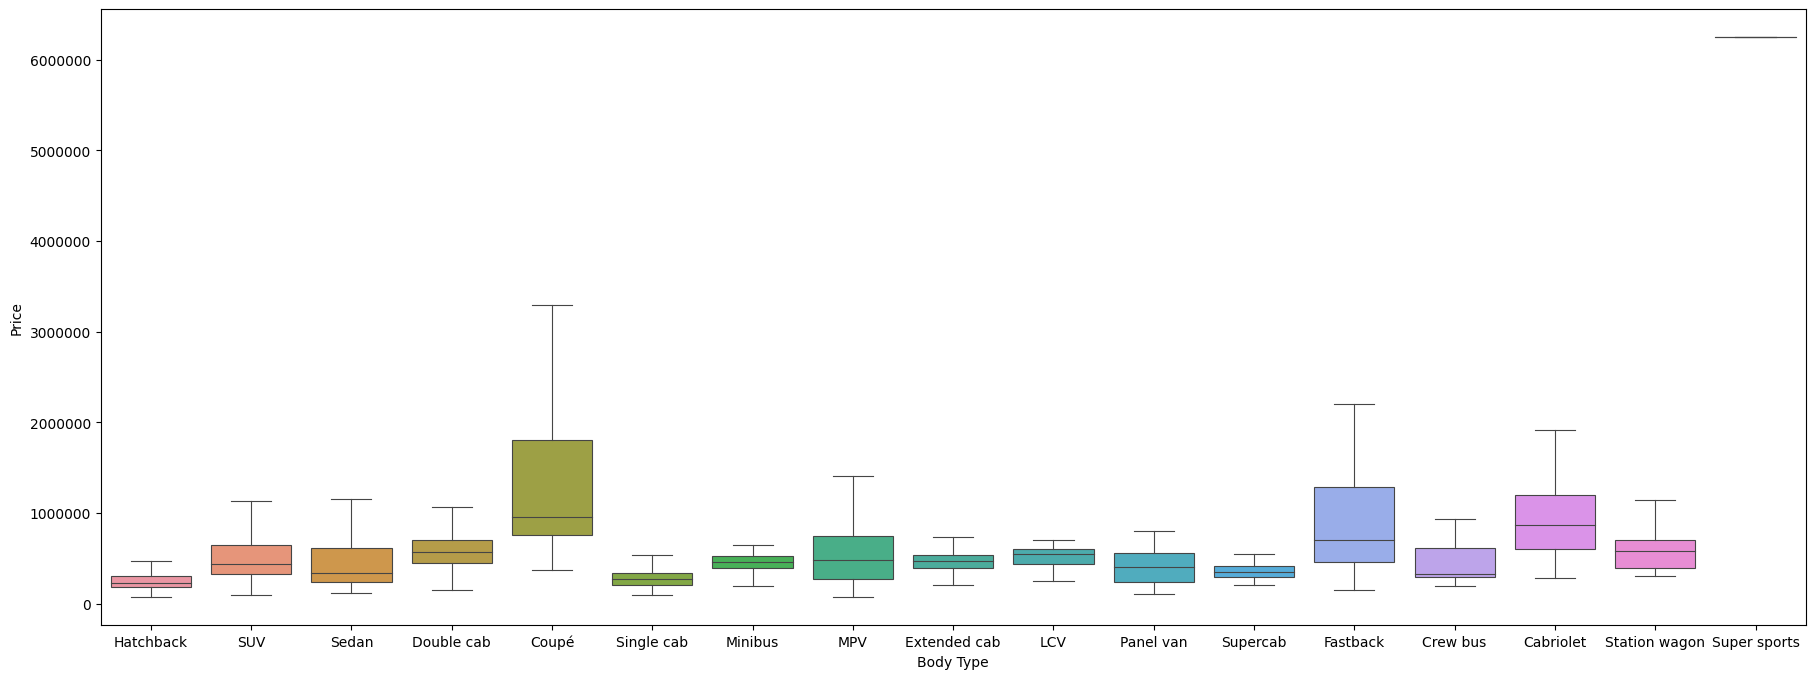

In [10]:
#body type and price
plt.figure(figsize=(22,8))
sns.boxplot(data=train,x='Body Type',y='Price',sym='',linewidth=0.8)
plt.ticklabel_format(style='plain',axis='y')
plt.show()

`From the plot above, it can be seen that Super sports body type have the highest median price, however, only one car with this body type is present in this dataset, and so we cannot say with full assurance that this body type is the most expensive unless we gather more cars with this body type and include them in the analysis.Apart from this rare instance, cars with coupe body type have the highest median price followed by the Cabriolet  body type `

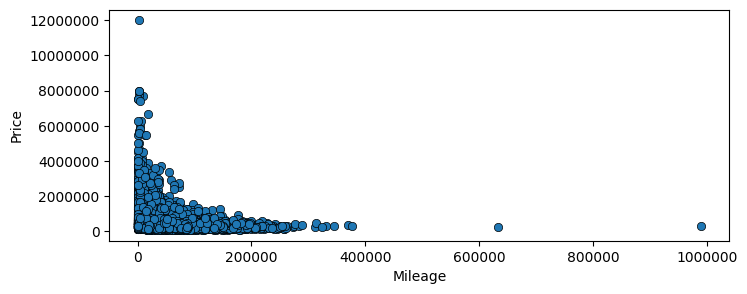

In [11]:
#check mileage and price
plt.figure(figsize=(8,3))
sns.scatterplot(data=train,x='Mileage',y='Price',edgecolor='black',linewidth=0.5)
plt.ticklabel_format(style='plain')
plt.show()

``` as expected, mileage has a negative realtionship with price, however this relationship is very weak  ```



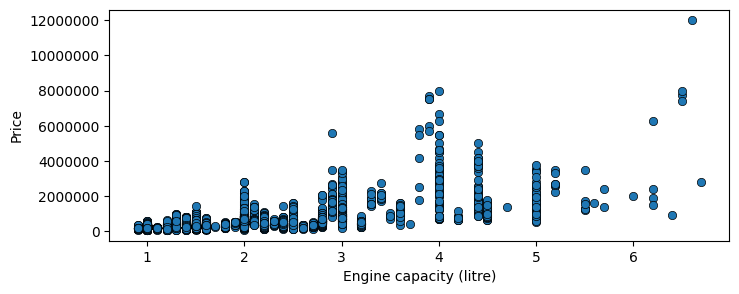

In [12]:
#Engine capacity (litre) and price
plt.figure(figsize=(8,3))
sns.scatterplot(data=train,x='Engine capacity (litre)',y='Price',edgecolor='black',linewidth=0.5)
plt.ticklabel_format(style='plain')
plt.show()

```Engine capacity (litre) has a strong positive relationship with price(i.e as engine capacity (litre) increases, price of the car increases,with other features being constant)```



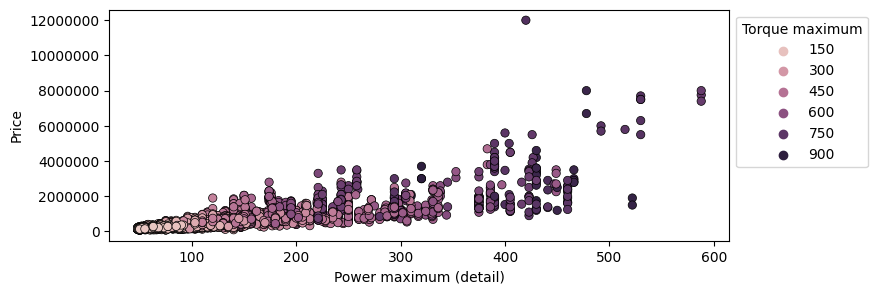

In [13]:
#Power maximum (detail), Torque maximum and price
plt.figure(figsize=(8,3))
sns.scatterplot(data=train,x= 'Power maximum (detail)',y='Price',hue= 'Torque maximum',edgecolor='black',linewidth=0.5)
plt.legend(bbox_to_anchor=(1, 1), loc=2,title='Torque maximum')
plt.ticklabel_format(style='plain')
plt.show()

`Both Power maximum detail and Torque maximum columns are strongly positively correlated with price. Also, we can clearly see that both variable are strongly correlated with one another, this is exepected, since a higher torque output means a higher potential for power output and vice versa.`

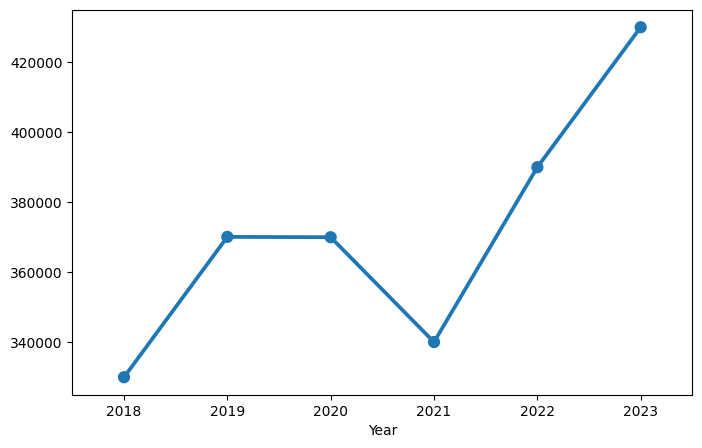

In [14]:
#year and price
median_price_per_year=train.groupby('Year')['Price'].median()

#plot
plt.figure(figsize=(8,5))
sns.pointplot(x=median_price_per_year.index,y=median_price_per_year.values)
plt.show()

`The lineplot above shows that the median prices of used cars manufactured in 2018 were the lowest compared to other years, while the median prices of cars produced in 2019 and 2020 were relatively similar. Although numerous external factors could have contributed to this pattern, it is unexpected to observe that used cars with a production year of 2021 have lower median prices than those made in 2019 and 2020, given that recent models are generally associated with higher prices. With the available data, we will attempt to determine the reason behind this trend.`

In [15]:
#compare car models based on year and numeric features
train.groupby('Year')[['Price', 'Mileage','Fuel capacity', 'Fuel consumption (average)',
       'Fuel range (average)', 'Power maximum (detail)', 'Torque maximum',
       'Acceleration 0-100 km/h', 'Maximum/top speed',
       'CO2 emissions (average)']].agg('median')

,Price,Mileage,Fuel capacity,Fuel consumption (average),Fuel range (average),Power maximum (detail),Torque maximum,Acceleration 0-100 km/h,Maximum/top speed,CO2 emissions (average)
Year,,,,,,,,,,
2018,329900.0,83000.0,60.0,6.2,917.0,110.0,280.0,10.3,190.0,156.0
2019,369997.0,67000.0,60.0,6.4,889.0,110.0,260.0,10.350000000000001,187.0,155.0
2020,369900.0,50700.0,55.0,6.3,825.0,105.0,233.0,10.4,187.0,150.0
2021,339950.0,34628.0,50.0,6.1,780.0,92.0,200.0,10.8,181.0,146.0
2022,389900.0,15095.5,51.0,6.2,774.0,103.0,200.0,10.0,183.0,147.0
2023,429900.0,1500.0,50.0,6.3,759.0,103.0,206.0,10.7,180.0,152.0


`On average, the mileage decreases with recency of the model. However, when examining specific car properties such as maximum power,maximum torque, fuel capacity, and top speed, it can be observed that cars produced in 2021 generally have lower values compared to other model years. However, these values are not substantial different from that of later models (2022, 2023). Therefore, there may be other variables beyond these numeric car properties that explain the lower median price of used cars with a production year of 2021.`

In [16]:
train.groupby('Year')[['Front tyres', 'Rear tyres']].agg(lambda x: x.mode())

,Front tyres,Rear tyres
Year,,
2018,265/60 R18,265/60 R18
2019,265/60 R18,265/60 R18
2020,265/60 R18,265/60 R18
2021,185/65 R15,185/65 R15
2022,265/60 R18,265/60 R18
2023,265/60 R18,265/60 R18


`it can be seen that the most frequent tyre size of 2021 cars is smaller than that of the other cars,the reason for lower median price of used cars with a production year of 2021 compared to than that of 2019 and 2020 could be due to a variety of factors such as condition of cars, regional market conditions,it's also possible that COVID-19 may have also played a role in the lower prices. However, it's important to note that further analysis would be needed to fully understand the reasons behind the lower median price.`

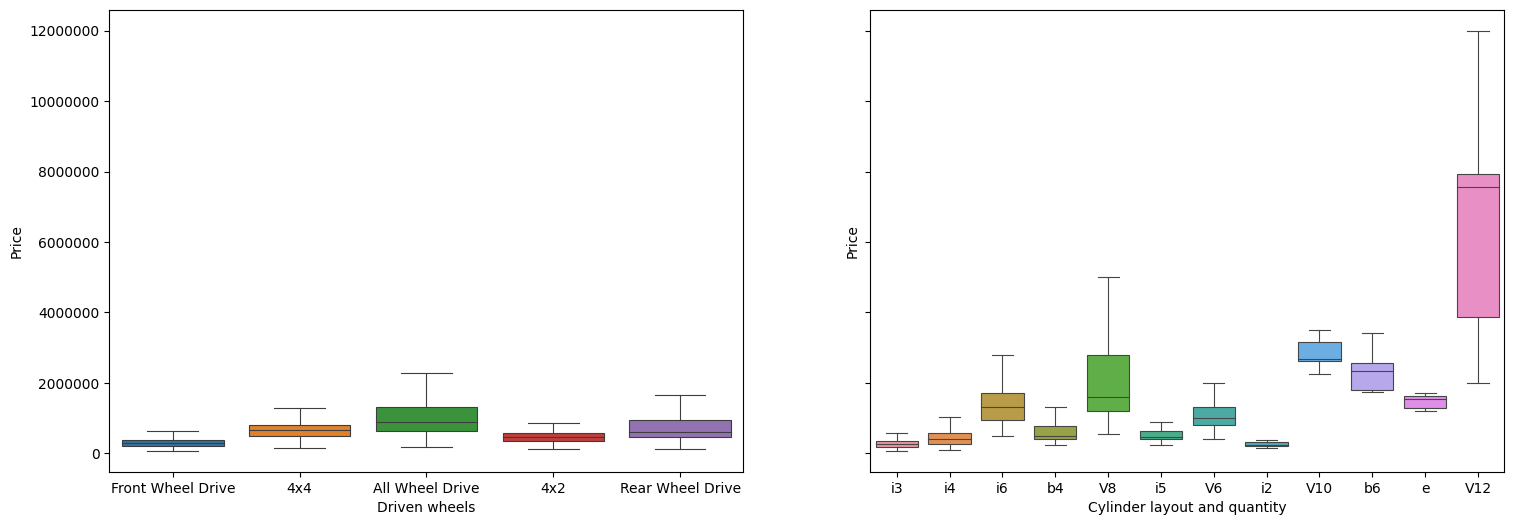

In [17]:
#Driven wheel,Cylinder layout and price
fig,ax=plt.subplots(1,2,figsize=(18,6),sharey=True)
sns.boxplot(data=train,x='Driven wheels',y='Price',sym='',linewidth=0.8,ax=ax[0])
sns.boxplot(data=train,x='Cylinder layout and quantity',y='Price',sym='',linewidth=0.8,ax=ax[1])
plt.ticklabel_format(style='plain',axis='y')
plt.show()

`from the charts, it can be seen that cars with all wheel drive are higher median price compared to other driven wheels type, also, cars with v12 cylinder layout have significant higher median price compared to the rest. This is expected as cars with V12 cylinders are typically high-end, luxury vehicles that are known for their exceptional performance and high price tags`

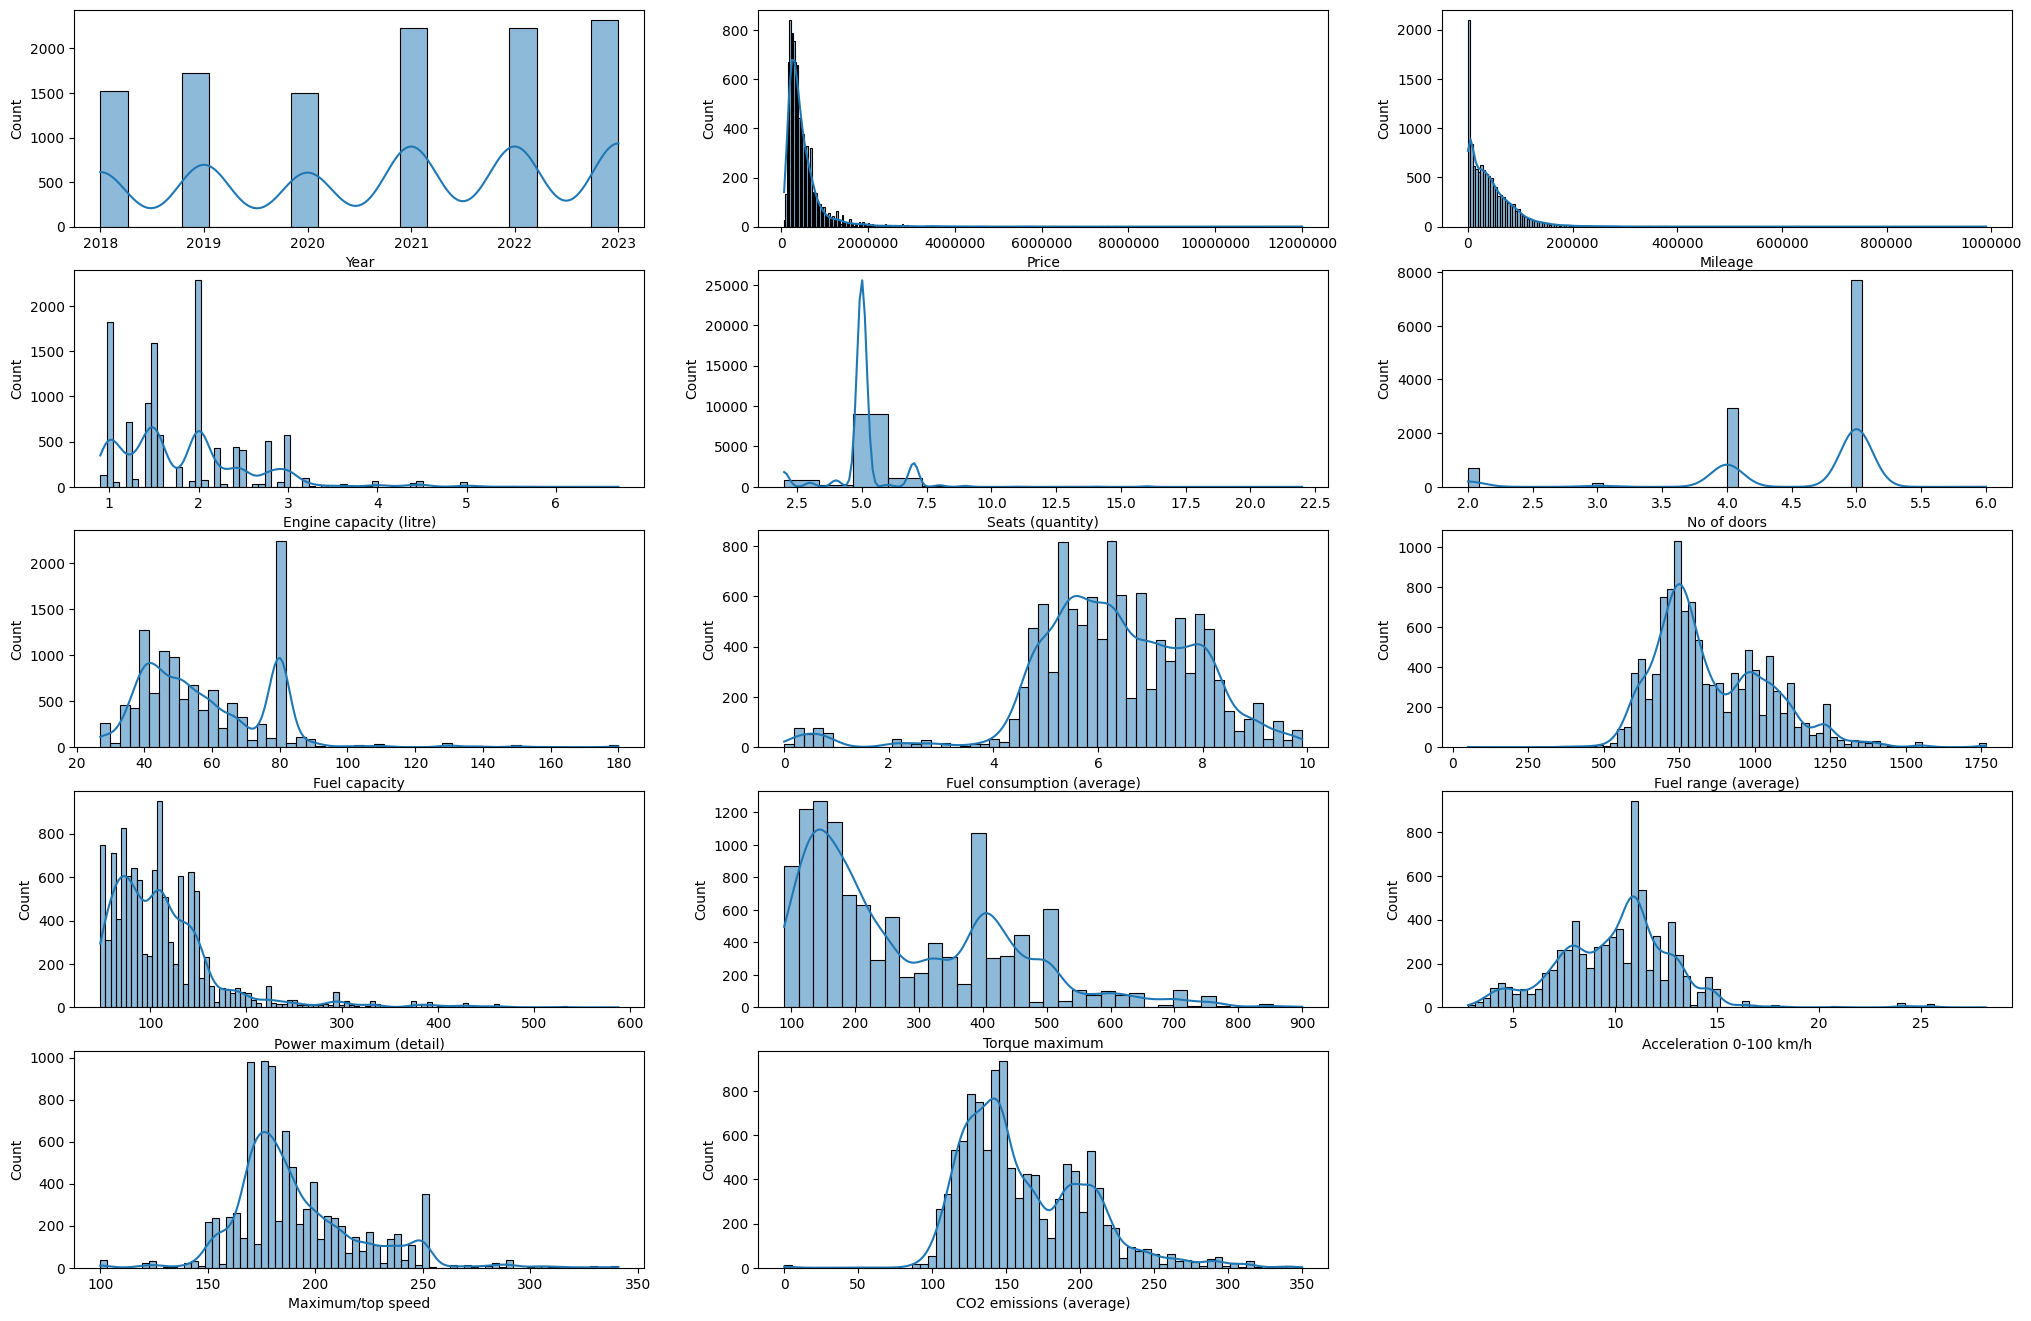

In [18]:
#check distribution of features
num_data=train.select_dtypes(include='number')
plt.figure(figsize=(25,40), facecolor='white')
plotnumber =1
for col in num_data.columns:
      ax = plt.subplot(12,3,plotnumber)
      sns.histplot(x=train[col],kde=True,edgecolor='black',linewidth=0.8)
      plt.ticklabel_format(style='plain',axis='x')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

```From the plots above, it can be observed that many of the variables including the target(Price) are skewed, most to the right and some to the left.However, Price and Mileage are heavily skewed to the right, because of this, relevant transformation such as log transformation will be applied in pipeline. many of these variables have outliers also.```



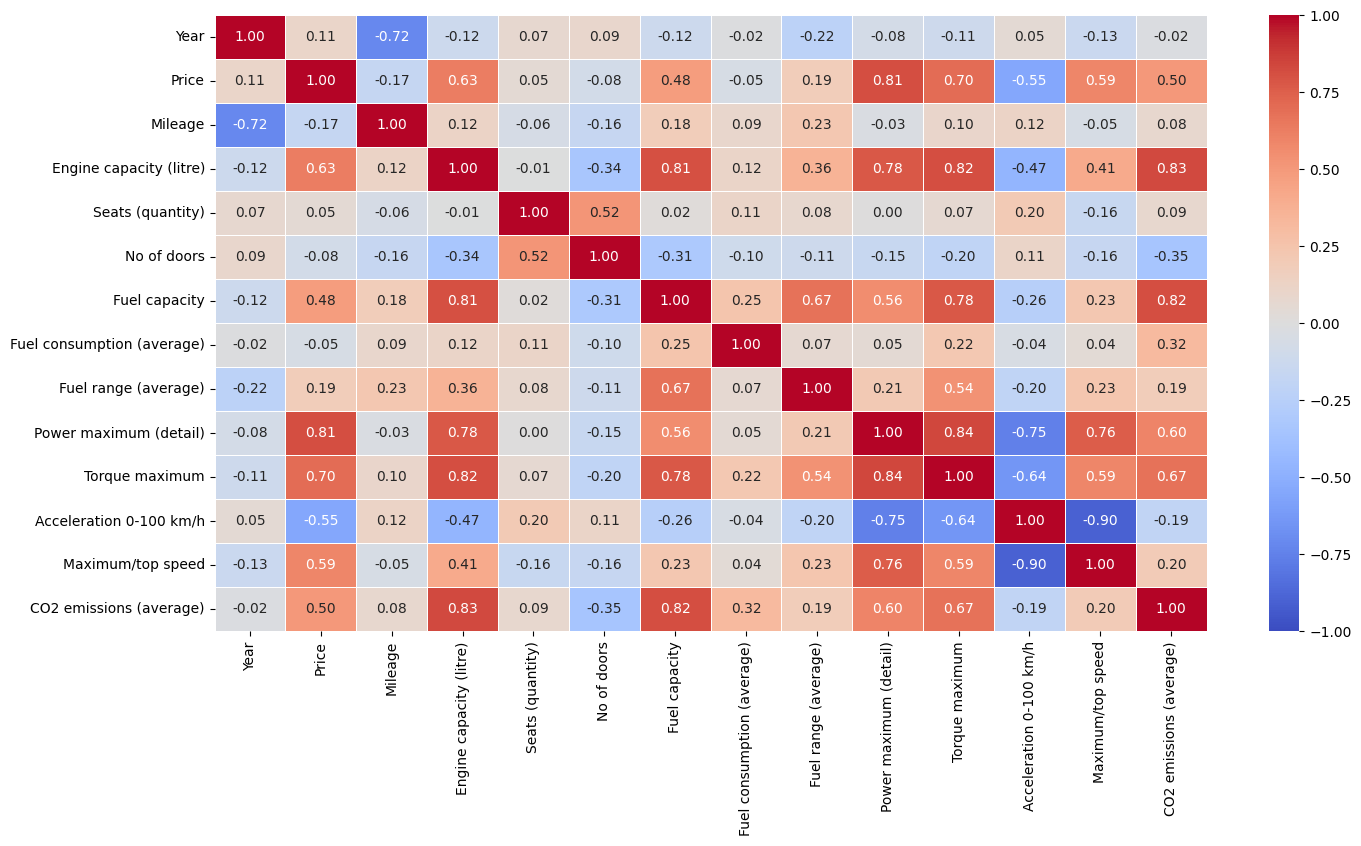

In [19]:
# Compute the correlation matrix
corr_matrix = num_data.corr()

# Plot the correlation heatmap using seaborn
plt.figure(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,fmt='.2f',linewidth=0.7)
plt.show()

`From the correlation heatmap,some of the features are correlated with the each other, for example, Power maximum (detail) has strong positive correlation of 0.84 with Torque maximum, this is expected as most car parts are related(totally dependent) on others. Multicollinearity affects interpretability of model by affecting coefficients but it doesnt affect prediction.`

In [20]:
#separate features and target in train and test set 
X_train=train.drop('Price',axis=1)
y_train=train['Price']
X_test=test.drop('Price',axis=1)
y_test=test['Price']


In [21]:
#change seats and no_of doors to categorical variable
X_train['Seats (quantity)']=X_train['Seats (quantity)'].astype('object')
X_test['Seats (quantity)']=X_test['Seats (quantity)'].astype('object')

X_train['No of doors']=X_train['No of doors'].astype('object')
X_test['No of doors']=X_test['No of doors'].astype('object')

#feature engineering
X_train['Driving_conditions'] = pd.cut(X_train['Mileage'], bins=[0, 5000, 15000, 30000, 50000, np.inf], 
                                       labels=['New', 'Light usage', 'Moderate usage', 'Heavy usage', 'Very heavy usage'])
X_test['Driving_conditions'] = pd.cut(X_test['Mileage'], bins=[0, 5000, 15000, 30000, 50000, np.inf], 
                                      labels=['New', 'Light usage', 'Moderate usage', 'Heavy usage', 'Very heavy usage'])

#drop mileage
X_train=X_train.drop('Mileage',axis=1)
X_test=X_test.drop('Mileage',axis=1)

### Modelling with outliers

In [22]:
#robust scaler
RS=RobustScaler()
#log transform function
LogTransform = FunctionTransformer(func=np.log, inverse_func=np.exp)
#catboost encoder
ce=CatBoostEncoder(a=1,sigma=0.1,random_state=15)


#remaining numerical columns
num_cols=X_train.select_dtypes(include='number').columns

#categorical columns
cat_cols=X_train.select_dtypes(include=['object','category']).columns.tolist()

#pipelines for preprocessing
num_pipeline=make_pipeline(SimpleImputer(strategy='median'),RS)

owners_cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),ce)

preprocessing= ColumnTransformer([('num',num_pipeline, num_cols),
                                ('owners_ordinal',owners_cat_pipeline,['Year']),
                                ('cat_enc',cat_pipeline,cat_cols)],
                                remainder='passthrough',) 

#feature selection using selectfrommodel with lightgbm as estimator
selector=make_pipeline(preprocessing, SelectFromModel(LGBMRegressor(random_state=20),max_features=10,threshold='median'))
#fit selectfromodel
selector=selector.fit(X_train,y_train)

#get selected features details
enc_features=preprocessing.named_transformers_['cat_enc']['catboostencoder'].get_feature_names_out()
labels = np.concatenate([num_cols,['Year'],enc_features])
selected=selector.named_steps['selectfrommodel'].get_feature_names_out(labels)

#print selected features
print('Selected features:',selected)

#transform train and test set to extract only selected features
X_train_selected=selector.transform(X_train)
X_test_selected=selector.transform(X_test)

Selected features: ['Year' 'Engine capacity (litre)' 'Fuel capacity' 'Power maximum (detail)'
 'Torque maximum' 'Acceleration 0-100 km/h' 'Maximum/top speed'
 'CO2 emissions (average)' 0 1]


In [23]:
#get features names for categorical features selected
selected_cat_col_index=[0,1]
selected_cat_cols=[]

#get the column names
for i in selected_cat_col_index:
  selected_cat_cols.append(cat_cols[i])

#replace (0,1) with original column names
selected=np.where(selected==[0],selected_cat_cols[0],selected)
selected=np.where(selected==[1],selected_cat_cols[1],selected)

#print selected features
print('selected features -',selected)

#make dataframe with selected columns
X_train_selected=pd.DataFrame(X_train_selected,columns=selected)
X_test_selected=pd.DataFrame(X_test_selected,columns=selected)


selected features - ['Year' 'Engine capacity (litre)' 'Fuel capacity' 'Power maximum (detail)'
 'Torque maximum' 'Acceleration 0-100 km/h' 'Maximum/top speed'
 'CO2 emissions (average)' 'Brand' 'Model']


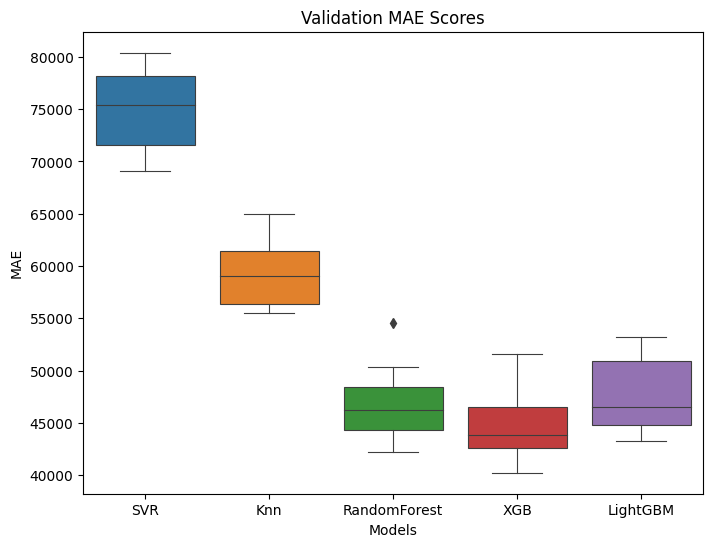

In [24]:
#Evaluation on 10-folds cross validation

rs=42 #random state

#models to evaluate
model_details={}
model_names=['SVR','Knn','RandomForest','XGB','LightGBM']
models=[SVR(kernel='rbf'), KNeighborsRegressor(), RandomForestRegressor( n_jobs=-1,random_state=rs),
        XGBRegressor(random_state=rs),LGBMRegressor(verbose=-1,random_state=rs)]

#get each model's scores
for name,model in zip(model_names,models):
  model=TransformedTargetRegressor(regressor=model, transformer=LogTransform)
  model.fit(X_train_selected,y_train)
  train_mae_score=mean_absolute_error(y_train, (model.predict(X_train_selected)))
  val_mae_scores=-cross_val_score(model,X_train_selected,y_train,cv=10,scoring='neg_mean_absolute_error')
  model_details[name]={'train_mae_score':train_mae_score,'val_mae_scores':val_mae_scores}

#compare cross validation scores using boxplot 
plt.figure(figsize=(8,6))
val_scores = [model_details[name]['val_mae_scores'] for name in model_names]
ax = sns.boxplot(data=val_scores,linewidth=0.8)
ax.set(title='Validation MAE Scores', ylabel='MAE', xlabel='Models')
ax.set_xticklabels(model_names)
plt.show()

`After evaluating the 5 models using 10-folds cross validation, Xgb model has the lowest median MAE score of about 44000. It should be noted that there are some outliers in the data that impact our model performance`

### Understanding outliers in data

In [25]:
#understanding outliers
numeric_data=X_train.select_dtypes('number')
round(numeric_data.describe(percentiles=[0.05, 0.5, 0.75,0.90, 0.95]),4)

,Year,Engine capacity (litre),Fuel capacity,Fuel consumption (average),Fuel range (average),Power maximum (detail),Torque maximum,Acceleration 0-100 km/h,Maximum/top speed,CO2 emissions (average)
count,11519.0,11501.0,11434.0,11084.0,11063.0,11452.0,11452.0,7028.0,8935.0,11131.0
mean,2020.7716,1.8446,57.8763,6.3122,853.9458,114.6321,278.1593,10.037,190.85,162.4125
std,1.6916,0.7487,18.8433,1.6037,188.0004,62.0968,156.6424,2.8248,29.1985,42.278
min,2018.0,0.9,27.0,0.0,51.0,48.0,89.0,2.8,100.0,0.0
5%,2018.0,1.0,35.0,4.4,613.0,50.0,96.0,4.9,155.0,112.0
50%,2021.0,1.6,54.0,6.3,798.0,103.0,220.0,10.4,183.0,149.0
75%,2022.0,2.2,76.0,7.5,988.0,135.0,400.0,11.6,205.0,192.0
90%,2023.0,2.8,80.0,8.2,1111.0,174.0,500.0,13.2,235.0,215.0
95%,2023.0,3.0,80.0,8.7,1214.0,225.0,580.0,14.4,250.0,238.0
max,2023.0,6.7,180.0,9.9,1765.0,588.0,900.0,28.2,341.0,350.0


`from the table above, it can be seen that for most features, the max value is quite far from the 95th percentile, which means the top 5% of most features are outliers. Also, for fuel range(average) and C02 emission features, the lower 5% are outliers.`

### Modelling without outliers

In [26]:
#without outliers
X_train_no_outliers=X_train.copy()
y_train_no_outliers=y_train.copy()
X_test_no_outliers=X_test.copy()
y_test_no_outliers=y_test.copy()

#drop outliers in train set
num_no=X_train_no_outliers.select_dtypes(include='number')
for col in num_no.columns:
  lower_lim=X_train_no_outliers[col].quantile(0.05)
  upper_lim=X_train_no_outliers[col].quantile(0.95)
  to_drop1=X_train_no_outliers[X_train_no_outliers[col]>upper_lim].index
  to_drop2=X_train_no_outliers[X_train_no_outliers[col]<lower_lim].index
  X_train_no_outliers.drop(index=to_drop1,inplace=True)
  X_train_no_outliers.drop(index=to_drop2,inplace=True)
  y_train_no_outliers.drop(index=to_drop1,inplace=True)
  y_train_no_outliers.drop(index=to_drop2,inplace=True)

#drop outliers in test set
num_no=X_test_no_outliers.select_dtypes(include='number')
for col in num_no.columns:
  lower_lim=X_test_no_outliers[col].quantile(0.05)
  upper_lim=X_test_no_outliers[col].quantile(0.95)  
  to_drop1=X_test_no_outliers[X_test_no_outliers[col]>upper_lim].index
  to_drop2=X_test_no_outliers[X_test_no_outliers[col]<lower_lim].index
  X_test_no_outliers.drop(index=to_drop1,inplace=True)
  X_test_no_outliers.drop(index=to_drop2,inplace=True)
  y_test_no_outliers.drop(index=to_drop1,inplace=True)
  y_test_no_outliers.drop(index=to_drop2,inplace=True)

In [27]:
#using selected features obtained from SelectFromModel

#encoder
ce=CatBoostEncoder(a=2,sigma=0.1,random_state=15)  
#pipelines for preprocessing

num_pipeline=make_pipeline(SimpleImputer(strategy='median'),RS)

owners_cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),OrdinalEncoder())

cat_pipeline=make_pipeline(SimpleImputer(strategy='most_frequent'),ce)

preprocessing= ColumnTransformer([('num',num_pipeline,['Power maximum (detail)','Torque maximum','Maximum/top speed']),
                                ('owners_ordinal',owners_cat_pipeline,['Year']),
                                ('cat_enc',cat_pipeline,['Brand','Model','Body Type','Seats (quantity)','Rear tyres','Driven wheels'])],
                                remainder='drop',) 

preprocessing=preprocessing.fit(X_train_no_outliers,y_train_no_outliers)

#transfrom sets
X_train_selected_no_outliers=preprocessing.transform(X_train_no_outliers)
X_test_selected_no_outliers=preprocessing.transform(X_test_no_outliers)


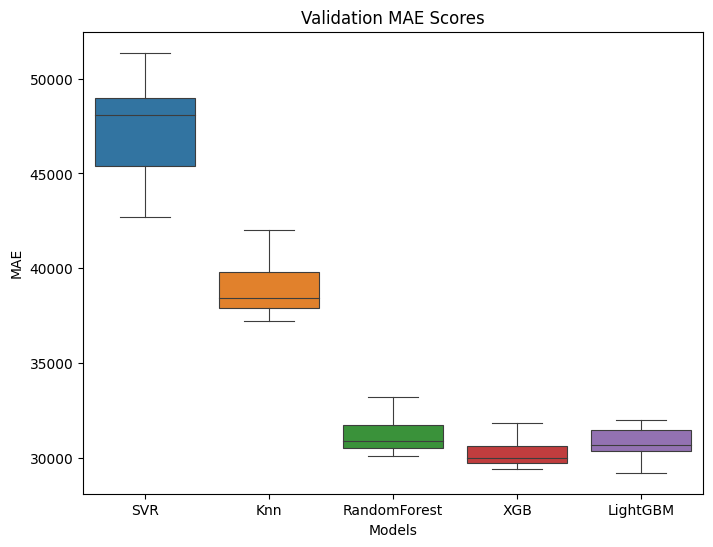

In [28]:
#models to evaluate
seed=12
model_details_no_outliers={}
model_names=['SVR','Knn','RandomForest','XGB','LightGBM']
models=[SVR(kernel='rbf'), KNeighborsRegressor(), RandomForestRegressor( n_jobs=-1,random_state=seed),
        XGBRegressor(random_state=seed),LGBMRegressor(verbose=-1,random_state=seed)]

#get each model's scores
for name,model in zip(model_names,models):
  model=TransformedTargetRegressor(regressor=model, transformer=LogTransform)
  model.fit(X_train_selected_no_outliers,y_train_no_outliers)
  train_mae_score=mean_absolute_error(y_train_no_outliers, (model.predict(X_train_selected_no_outliers)))
  val_mae_scores=-cross_val_score(model,X_train_selected_no_outliers,y_train_no_outliers,cv=10,scoring='neg_mean_absolute_error')
  model_details_no_outliers[name]={'train_mae_score':train_mae_score,'val_mae_scores':val_mae_scores}

#compare cross validation scores using boxplot 
plt.figure(figsize=(8,6))
val_scores = [model_details_no_outliers[name]['val_mae_scores'] for name in model_names]
ax = sns.boxplot(data=val_scores,linewidth=0.8)
ax.set(title='Validation MAE Scores', ylabel='MAE', xlabel='Models')
ax.set_xticklabels(model_names)
plt.show()

`it can been seen that all the models performed better after removing outliers, Xgb which has the lowest median Validation MAE score has a validation score of around 30000 which is almost 14000 lesser than its Validation MAE score when modelling was done with outliers done. `

### Comparison Of Modelling Results.

In [29]:
#score for model with outliers 
model_val_mae_scores1={}
for key in model_details.keys():
  model_val_mae_scores1[key]=np.median(model_details[key]['val_mae_scores'])

#score for model without outlier
model_val_mae_scores2={}
for key in model_details_no_outliers.keys():
  model_val_mae_scores2[key]=np.median(model_details_no_outliers[key]['val_mae_scores'])

#make result datframe
result=pd.DataFrame([model_val_mae_scores1,model_val_mae_scores2])
diffrence=pd.DataFrame((result.iloc[0,:]-result.iloc[1,:])).T
result=pd.concat([result,diffrence],ignore_index=True)
result.rename(index={0:'10-folds Cross Validation MAE score with outliers',
                     1:'10-folds Cross Validation MAE score without outliers',2:'diffrence'},inplace=True)

#result dataframe
result


,SVR,Knn,RandomForest,XGB,LightGBM
10-folds Cross Validation MAE score with outliers,75438.5792359066,59005.818666601044,46184.25924879691,43848.63521999783,46477.998620323284
10-folds Cross Validation MAE score without outliers,48081.1563011485,38410.09955938687,30860.355203163374,29980.96342503054,30659.596927647886
diffrence,27357.4229347581,20595.719107214172,15323.904045633535,13867.67179496729,15818.401692675397


`the table above shows the result of modelling with and without outliers. overall, all the models performed much better after outliers were removed. The best model over all is XGBRegressor model.`

`The implications of these results are as follows:`

`Impact of outliers: The presence of outliers has a substantial effect on the performance of the regression models. The average error (MAE) for all models decreases considerably when outliers are removed, indicating that outliers have a considerable influence on the predictions.`

`XGBRegressor performance: Among the tested models, XGBRegressor demonstrated the best performance in terms of MAE. This model consistently yielded the lowest error both with and without outliers, suggesting its robustness and effectiveness for this particular regression task.`

`Model comparison: While XGBRegressor outperformed the other models, it's worth noting that all models experienced a significant improvement when outliers were removed. This implies that outlier removal has a positive impact across different regression algorithms, potentially leading to more accurate predictions.`

`Financial implications: The difference in average error between the model with outliers and the model without outliers provides a quantitative measure of the financial implications. In this case, the XGBRegressor model reduces the error from approximately $44861 to $29950 on average when outliers are removed. This improvement has potential financial benefits, as more accurate predictions can lead to better decision-making and resource allocation.`


In [30]:
#save data for hyparameter tunning

# Define the file path
#file_path = '/content/drive/MyDrive/Datascience_projects/Autotrader_SA/train_hyperparameter_tuning/train__no_outliers.joblib'

# Save X_train_selected_no_outliers and y_train_no_outliers in a joblib file
#data_to_save = {'X_train': X_train_selected_no_outliers,'y_train': y_train_no_outliers}

#joblib.dump(data_to_save, file_path)

### Evaluation on separate test set

In [31]:
#evaluation on test set
final_estimator=XGBRegressor(n_estimators= 900, max_depth= 4, learning_rate= 0.09683919591334456, gamma= 0.00015286854567638669, colsample_bytree= 0.5, 
                             min_child_weight= 10, subsample= 0.8380391485033669, 
                             reg_alpha= 0.022198038157775324, reg_lambda= 7.569387456939101,random_state=15)
final_estimator=TransformedTargetRegressor(regressor=final_estimator, transformer=LogTransform)
final_estimator=final_estimator.fit(X_train_selected_no_outliers,y_train_no_outliers)
# Predict on the test set and transform predictions back to the original scale
final_preds= final_estimator.predict(X_test_selected_no_outliers)
# Calculate evaluation metrics on the original scale
train_mae= mean_absolute_error(y_train_no_outliers, (final_estimator.predict(X_train_selected_no_outliers)))
test_mae = mean_absolute_error(y_test_no_outliers, final_preds)
test_r2 = r2_score(y_test_no_outliers, final_preds)
# Print the evaluation metrics
print(f"MAE on train set: {train_mae:.2f}")
print(f"MAE on test set: {test_mae:.2f}")
print(f"R2 score on test set: {test_r2:.2f}")

MAE on train set: 24804.98
MAE on test set: 29908.83
R2 score on test set: 0.94


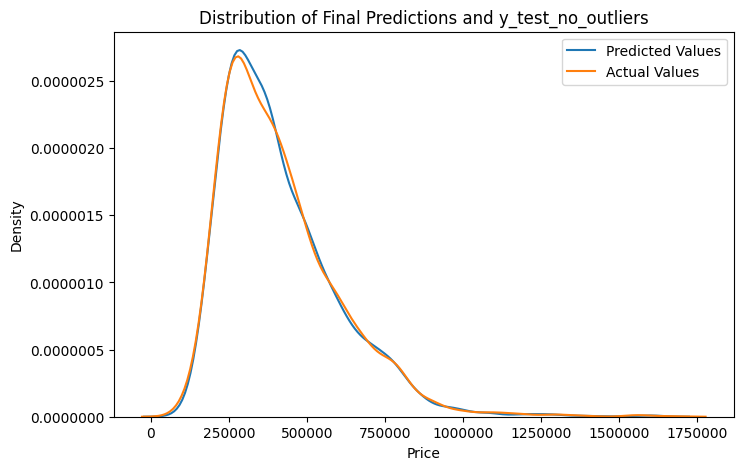

In [32]:
# Plot distribution of final predictions and y_test_no_outliers
plt.figure(figsize=(8,5))
sns.kdeplot(final_preds, label='Predicted Values')
sns.kdeplot(y_test_no_outliers, label='Actual Values')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Distribution of Final Predictions and y_test_no_outliers')
plt.ticklabel_format(style='plain')
plt.show()


`the plot above shows the distribution of the predicted values and the actual values are very close, meaning the our predicted values are almost the same as original values`

In [33]:
#needed details
brand=sorted(list(X_train_no_outliers['Brand'].unique()))
model=sorted(list(X_train_no_outliers['Model'].unique()))
seats=[5, 7, 2, 4, 3, 8, 6, 16, 22]
body_type=sorted(list(X_train_no_outliers['Body Type'].dropna().unique()))
rear_tyres=sorted(list(X_train_no_outliers['Rear tyres'].dropna().unique()))
driven_wheels=sorted(list(X_train_no_outliers['Driven wheels'].dropna().unique()))


#save model
file_to_dump={'xgb_model':final_estimator,'preprocessing':preprocessing,
              'brand':brand,'model':model,'seats':seats,'body_type':body_type,
              'rear_tyres':rear_tyres,'driven_wheels':driven_wheels}

joblib.dump(file_to_dump, '/content/drive/MyDrive/Datascience_projects/Autotrader_SA/final_model_details.joblib')

['/content/drive/MyDrive/Datascience_projects/Autotrader_SA/final_model_details.joblib']